In [1]:
import networkx as nx
from collections import deque
import string
import matplotlib.pyplot as plt

In [2]:

class Node(object):
    def __init__(self, name):
        self.name = name 
        self.connections = []
    
    def __str__(self):
        return self.name

    
class Tree(object):
    def __init__(self, root_node = None ):
        
        if root_node:
            self.root_node = root_node
        else:
            self.root_node = Node('A')
    
    def nodes(self):
        node_set = set()
        leaves = deque([self.root_node])
        while len(leaves):
            leav = leaves.popleft()
            yield leav
            for cild in leav.connections:
                if cild not in node_set:
                    leaves.append(cild)
                    node_set.add(cild)
                    
    

In [18]:
def NamesGenerator():
    """Create node names iterator.
    All names consists of upper laters and
    names follows in lexical order.
    """
    
    g_index = 1
    while True:
        name = []
        inx = g_index
        p_size = len(string.ascii_uppercase)
        while True:
            remainder = inx % p_size
            inx = inx // p_size
            name.append(string.ascii_uppercase[remainder])
            if inx == 0: break

        yield "".join(name)
        g_index += 1

def generate_tree(depth = 5, leave_count = 3):
    tree = Tree()
    leaves = [tree.root_node]

    name_generator = NamesGenerator()

    for _ in range(depth):
        new_leaves = []
        for leave in leaves:
            for _ in range(leave_count):
                new_child = Node(name_generator.__next__())
                leave.connections.append(new_child)
                new_leaves.append(new_child)
        leaves = new_leaves
    return tree
    

def save_tree(tree, fname):
    with open(fname, "w") as file:
        for node in tree.nodes():
            for child in node.connections:
                file.write("{pname}->{cname};\n".format(pname=node,cname=child))

class NoRootException(Exception):
    def __init__(self, count):

        message = "{} root_condidates".format(str(count))
        super(NoRootException, self).__init__(message)

        
def load_tree(fname, plain_file = True):
    
    connections = []

    if len(fname.split()) > 1 and fname.split()[-1] == "dot":
        G = nx.drawing.nx_pydot.read_dot(fname)
        connections = [ (edge[0], edge[1]) for edge in G.edges ]
    else:
        with open(fname, "r") as file:
            lines = file.readlines()
            for line in lines:
                node_names = line.split(';')[0].split('->')
                connections.append(nodes_names)
        
            
    nodes = dict()
    nodes_with_input = set()
    
    for node_names in connections:
        cfrom, cto = node_names
        nodes[cfrom] = nodes.get(cfrom, Node(cfrom))
        nodes[cto] = nodes.get(cto, Node(cto))
        
        nodes[cfrom].connections.append(nodes[cto])
        nodes_with_input.add(cto)
        
    root_condidates = list(set(nodes.keys()).difference(nodes_with_input))
    
    if len(root_condidates) != 1:
        raise NoRootException(len(root_condidates))
    
    return Tree(nodes[root_condidates[0]])
                        
                    
def to_nx_graph(tree):
    G=nx.DiGraph()
    for node in tree.nodes():
        for child in node.connections:
            G.add_edge(node,child)     
    return G    

    

def draw_tree(tree, fname = None):       
    G = to_nx_graph(tree)
    nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G))
    
    if fname:
        plt.savefig(fname, format="PNG")
        plt.close()
    else:
        plt.show()
        


In [4]:
class CircleInTreeException(Exception):
    def __init__(self, node):

        message = "{} detected twice".format(str(node))
        super(CircleInTreeException, self).__init__(message)

        
def df_traversal(tree):

    ways = deque([])
    
    root_node = tree.root_node 
    curent_path = deque([ [root_node,0] ])
    
    while len(curent_path):
        
        last_path_entry = curent_path[-1]
        curent_node, next_cild_inx = last_path_entry
            
        
        if not len(curent_node.connections):
            #curent_node is a leave node
            ways.append([ node for node, it in curent_path ] )
            #go back
            curent_path.pop()
            
        elif len(curent_node.connections) ==  next_cild_inx:
            #there isn't more cildren nodes
            #go back
            curent_path.pop()
            
        else:
            #there is an avaliable next cildren node
            #go to the next cildren, make it curent
            next_cild_node = curent_node.connections[next_cild_inx]
            
            #check for circles in path
            if len([ 1 for node, inx  in curent_path if node == next_cild_node ]):
                raise CircleInTreeException(next_cild_node)
                
            curent_path.append( [next_cild_node,0] )
            
            last_path_entry[1] += 1
            
    
    return ways
             


In [5]:
#large tree for speed test
tree = generate_tree(depth = 12, leave_count = 3)

In [6]:
%%time
ways = df_traversal(tree)

CPU times: user 10.6 s, sys: 180 ms, total: 10.8 s
Wall time: 10.8 s


In [7]:
def ways_count(depth, leave_count):
    return leave_count**depth

def way_to_str(way, delimiter = ""):
    return delimiter.join([ str(n) for n in way ])

['AC', 'ABC', 'ADEF', 'ADGH', 'ADGI']


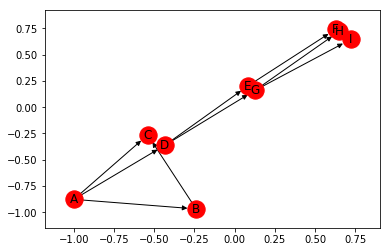

In [19]:
tree = load_tree('tree-task.dot', plain_file = False)
ways = df_traversal(tree)
print([ way_to_str(w) for w in ways ] )

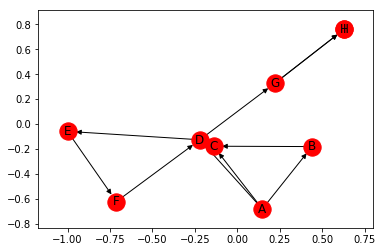

In [9]:
#add circles to graph
D_node = [ n for n in tree.nodes() if str(n) == "D" ][0]
F_node =[ n for n in tree.nodes() if str(n) == "F" ][0]
#make a circle
F_node.connections.append(D_node)
draw_tree(tree)

In [10]:
#must be CircleInTreeException exception
ways = df_traversal(tree)

CircleInTreeException: D detected twice

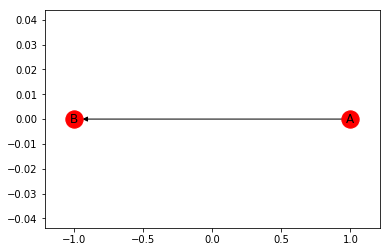

way count:1
['AB']


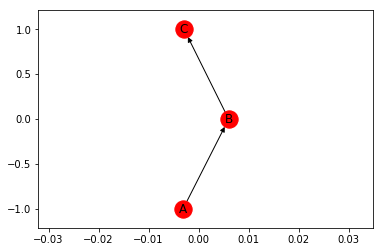

way count:1
['ABC']


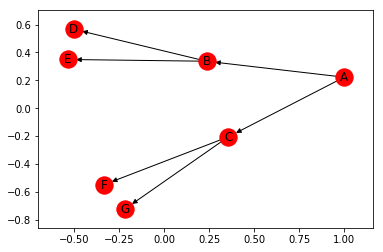

way count:4
['ABD', 'ABE', 'ACF', 'ACG']


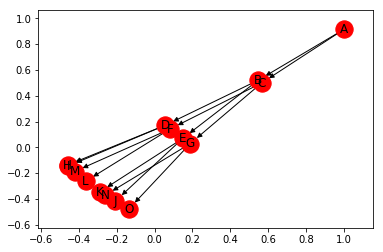

way count:8
['ABDH', 'ABDI', 'ABEJ', 'ABEK', 'ACFL', 'ACFM', 'ACGN', 'ACGO']


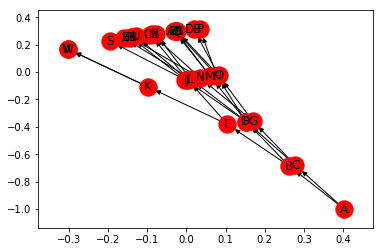

way count:16


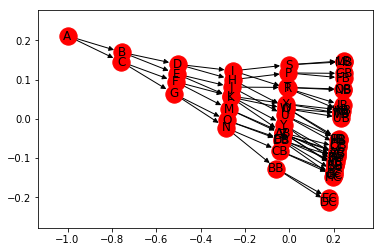

way count:32


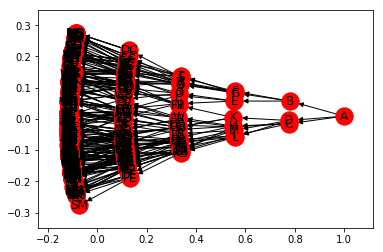

way count:243


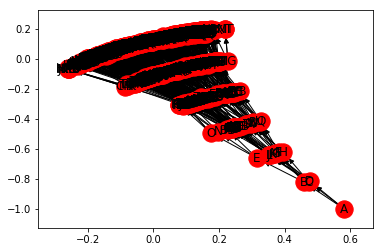

way count:729


In [11]:
#generates test files


tests = [{'depth':1, 'leave_count': 1},
        {'depth':2, 'leave_count': 1},
         {'depth':2, 'leave_count': 2},
        {'depth':3, 'leave_count': 2},
        {'depth':4, 'leave_count': 2},
        {'depth':5, 'leave_count': 2},
        {'depth':5, 'leave_count': 3},
        {'depth':6, 'leave_count': 3},]

for inx, test in enumerate(tests):
    tree = generate_tree(**test)
    ways = df_traversal(tree)
    
    draw_tree(tree)
    
    print('way count:{}'.format(ways_count(**test)))
    if len(ways) < 10:
        print([ way_to_str(w) for w in ways ] )
        
    save_tree(tree, 'test{}.tr'.format(inx))
    
        

In [12]:
!cat test3.tr

A->B;
A->C;
B->D;
B->E;
C->F;
C->G;
D->H;
D->I;
E->J;
E->K;
F->L;
F->M;
G->N;
G->O;
